In [1]:
import cv2
import glob
import tensorflow as tf
import numpy as np
import pickle
import os
import numpy as np
import re

In [2]:
# image related data
images_name = []
images_list = []
images_features = {}
img_features_path = os.path.join('../dataset/pkl/train2048.pkl')

# caption related data
captions_list = []
captions_mapped = {}
vocab = {}
vocab_path = os.path.join('../dataset/pkl/vocab.pkl')


# encode model for preprocessing
x = tf.keras.applications.vgg16.VGG16()
encode_model = tf.keras.models.Model(x.input, outputs=x.layers[-2].output)

In [3]:
path = '../dataset/images/Flicker8k_Dataset/*.jpg'

if not os.path.exists(img_features_path):
    for img in glob.glob(path):
        name = img.split('/')[-1]
        images_name.append(name)
        # passing image to model
        image = tf.keras.preprocessing.image.load_img(img, target_size=(224,224))
        i = tf.keras.preprocessing.image.img_to_array(image, dtype=np.float32)
        i = i.reshape((1,i.shape[0],i.shape[1],i.shape[2]))
        i = tf.keras.applications.vgg16.preprocess_input(i)
        i = encode_model.predict(i, verbose=0)
        images_features[name] = i
        
    with open(img_features_path, 'wb') as f:
        pickle.dump(images_features, f)
else:
    print('File already exist, opening...')
    with open(img_features_path, 'rb') as f:
        images_features = pickle.load(f)
        
        for img in glob.glob(path):
            name = img.split('/')[-1]
            images_name.append(name)

File already exist, opening...


In [4]:
f = open('../dataset/text/Flickr8k.token.txt', 'rb')
captions_list = f.read().decode('utf-8').split('\n')


for i in captions_list:
    name = i.split('\t')[0][:-2]
    caption = i.split('\t')[1]
    caption = caption.lower()
    caption = re.sub(r'[^\w\s]','',caption)
    caption = 'sequencestart ' + caption + ' sequenceend'
    if name in images_name:
        if name not in captions_mapped:
            captions_mapped[name] = [caption]
        else:
            captions_mapped[name].append(caption)
            
print(captions_mapped['2938120171_970564e3d8.jpg'])

['sequencestart a large dog sniffing a smaller dog outside  sequenceend', 'sequencestart two blond dogs are standing together on a patio  sequenceend', 'sequencestart two dogs are standing together on a patio  sequenceend', 'sequencestart two golden dogs are standing on a wooden patio  sequenceend', 'sequencestart two golden dogs on a wood deck  sequenceend']


In [5]:
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in captions_list:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d ==> %d' % (len(word_counts), len(vocab)))

preprocessed words 49584 ==> 1939


In [6]:
MAX_LEN = 0
for img_name, captions in captions_mapped.items():
    for caption in captions:
        if len(caption) > MAX_LEN and len(caption) < 34:
            MAX_LEN = len(caption)
MAX_LEN

33

In [7]:
idxtoword = {}
wordtoidx = {}

ix = 1
for w in vocab:
    wordtoidx[w] = ix
    idxtoword[ix] = w
    ix += 1
    
vocab_size = len(idxtoword) + 1 

In [8]:
def create_seq(captions, photo):
    X1, X2, y = [], [], []
    for caption in captions:
        seq = [wordtoidx[word] for word in caption.split(' ') if word in wordtoidx]
        for i in range(1, len(seq)):
            in_seq, out_seq = seq[:i], seq[i]

            in_seq = tf.keras.preprocessing.sequence.pad_sequences(
                [in_seq], 
                maxlen=MAX_LEN)[0]

            out_seq = tf.keras.utils.to_categorical([out_seq], num_classes=len(vocab)+1)[0]
            
            X1.append(photo)
            X2.append(in_seq)
            y.append(out_seq)
    return np.array(X1), np.array(X2), np.array(y)

In [9]:
def generator(captions_dict):
    while True:
        for img_name, caption in captions_dict.items():
            img = images_features[img_name].reshape(4096,)
            x1, x2, y = create_seq(caption, img)
            yield [x1, x2], y

In [33]:
def architecture():
    # creating feature extractor model
    feature_model_input =  tf.keras.layers.Input(shape=(4096,), name='feature_input')
    feature_model_dropout = tf.keras.layers.Dropout(0.2)(feature_model_input)
    feature_model_dense = tf.keras.layers.Dense(256, activation='relu')(feature_model_dropout)
    feature_image_repeat = tf.keras.layers.RepeatVector(n=MAX_LEN)(feature_model_dense)
    
    # creating recurrent model
    recurrent_model_input = tf.keras.layers.Input(shape=(MAX_LEN,))
    recurrent_model_embedding = tf.keras.layers.Embedding(len(vocab)+1, 256, mask_zero=True)(recurrent_model_input)

    # adding models 
    final_model = tf.keras.layers.Concatenate()([feature_image_repeat, recurrent_model_embedding])
    final_model_lstm = tf.keras.layers.LSTM(256)(final_model)
    final_model_dense = tf.keras.layers.Dense(256, activation='relu')(final_model_lstm)
    output = tf.keras.layers.Dense(len(vocab)+1, activation='softmax')(final_model_dense)

    # creating keras model object
    model = tf.keras.models.Model(inputs=[feature_model_input, recurrent_model_input], outputs=output)
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    return model

In [34]:
model = architecture()
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
feature_input (InputLayer)      [(None, 4096)]       0                                            
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 4096)         0           feature_input[0][0]              
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 256)          1048832     dropout_2[0][0]                  
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 33)]         0                                            
____________________________________________________________________________________________

In [35]:
# train the model, run epochs manually and save after each epoch
epochs = 20
num_images = 1
steps = len(captions_mapped) // num_images
for i in range(epochs):
    # create the data generator
    gen = generator(captions_mapped)
    # define checkpoint callback
    filepath = 'models/model-loss{loss:.3f}.h5'
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='loss', verbose=1,
                save_best_only=True, mode='min')
    # fit for one epoch
    model.fit_generator(gen, epochs=1, steps_per_epoch=steps, verbose=1, callbacks=[checkpoint])
    # save model and weights
    model.save('models/model_at_epoch_' + str(i) + '.h5')

8091/8091 [==============================] - 1265s 156ms/step - loss: 4.6122 - accuracy: 0.1886

Epoch 00001: loss improved from inf to 4.14838, saving model to models/model-loss4.148.h5
8091/8091 [==============================] - 1299s 161ms/step - loss: 3.4392 - accuracy: 0.2934

Epoch 00001: loss improved from inf to 3.43921, saving model to models/model-loss3.439.h5
8091/8091 [==============================] - 1258s 156ms/step - loss: 3.2390 - accuracy: 0.3118

Epoch 00001: loss improved from inf to 3.23902, saving model to models/model-loss3.239.h5
8091/8091 [==============================] - 1241s 153ms/step - loss: 3.1299 - accuracy: 0.3228

Epoch 00001: loss improved from inf to 3.12995, saving model to models/model-loss3.130.h5
8091/8091 [==============================] - 1251s 155ms/step - loss: 3.0585 - accuracy: 0.3307

Epoch 00001: loss improved from inf to 3.05852, saving model to models/model-loss3.059.h5
8091/8091 [==============================] - 1254s 155ms/step - l

In [60]:
# generate caption
def exctract_img_features(img):
    image = cv2.imread(img)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224,224))
    i = tf.keras.preprocessing.image.img_to_array(image, dtype=np.float32)
    i = image.reshape((1,i.shape[0],i.shape[1],i.shape[2]))
    i = tf.keras.applications.vgg16.preprocess_input(i)
    features = encode_model.predict(i)
    return features

def word_by_token(value):
    for word, index in vocab.items():
        if index == value:
            return word
    return None

def generate_caption(model, photo):
    in_text = 'sequencestart'
    for i in range(15):
        sequence = [wordtoidx[w] for w in in_text.split() if w in wordtoidx]
        sequence = tf.keras.preprocessing.sequence.pad_sequences([sequence], maxlen=MAX_LEN)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idxtoword[yhat]
        in_text += ' ' + word
        if word == 'sequenceend':
            break
            
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

65


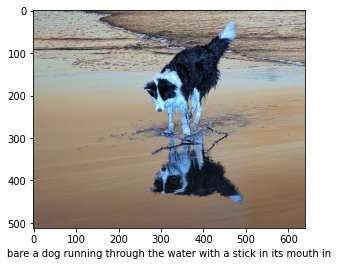

In [62]:
import matplotlib.pyplot as plt
path = '../example.jpg'
i = exctract_img_features(path)
model = tf.keras.models.load_model('../src/models/model-loss2.795.h5')
caption = generate_caption(model, i)
image = cv2.imread(path)
plt.imshow(image)
plt.xlabel(caption)
print(len(caption))